In [1]:
#coding=utf-8
import os
import random
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import pickle as pickle
import copy
from tqdm import tqdm
import torch, torchvision
from torchvision import transforms
from torchvision.models import ResNet50_Weights
import glob
import shutil
import time,math
import torch
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

###########set the visible GPU cards#################
def set_gpu_envs(gpu_list):
    gpu_envs_str = ''
    if len(gpu_list) == 1:
        gpu_envs_str = str(gpu_list[0])
    else:
        for idx in range(len(gpu_list)-1):
            gpu_envs_str += (str(gpu_list[idx])+',')
        gpu_envs_str += str(gpu_list[-1])
        
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_envs_str
    return gpu_envs_str
###############################################

def spatial_random(imgdata, imgwith=224):
    transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(imgwith),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                   std=(0.229, 0.224, 0.225)),
        ])
    return transform(imgdata)

def spatial_center(imgdata, imgwith=224):
    transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(int(imgwith*8/7)),# Let smaller edge match
            torchvision.transforms.CenterCrop(imgwith),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                   std=(0.229, 0.224, 0.225)),
        ])
    return transform(imgdata)

def process_image(imgdata, resize_width, transfer_mode): 

    if transfer_mode == 'random':
        imgdata = spatial_random(imgdata, resize_width)
        
    if transfer_mode == 'center':
        imgdata = spatial_center(imgdata, resize_width)

    return imgdata

class ResNet(nn.Module):

    def __init__(self, features_base, feature_branch_list, fc_indim=512*4, grid_rate=1, num_classes=[13,37,122,200]):
        super(ResNet, self).__init__()
        
        self.features_base = features_base
        self.features_branch_1 = feature_branch_list[0]
        self.features_branch_2 = feature_branch_list[1]
        self.features_branch_3 = feature_branch_list[2]
        self.features_branch_4 = feature_branch_list[3]
        
        self.fc_ori_1 = nn.Linear(fc_indim, num_classes[0])
        self.fc_ori_2 = nn.Linear(fc_indim, num_classes[1])
        self.fc_ori_3 = nn.Linear(fc_indim, num_classes[2])
        self.fc_ori_4 = nn.Linear(fc_indim, num_classes[3])
        
        self.averpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        b,c,w,h = x.size()
        x = self.features_base(x)
        
        x_out_1 = self.features_branch_1(x.detach())
        x_out_1 = self.averpool(x_out_1).view(b, -1)
        x_out_1 = self.fc_ori_1(x_out_1)
        
        x_out_2 = self.features_branch_2(x.detach())
        x_out_2 = self.averpool(x_out_2).view(b, -1)
        x_out_2 = self.fc_ori_2(x_out_2)
        
        x_out_3 = self.features_branch_3(x.detach())
        x_out_3 = self.averpool(x_out_3).view(b, -1)
        x_out_3 = self.fc_ori_3(x_out_3)
        
        x_out_4 = self.features_branch_4(x)
        x_out_4 = self.averpool(x_out_4).view(b, -1)
        x_out_4 = self.fc_ori_4(x_out_4)

        return [x_out_1,x_out_2,x_out_3,x_out_4]
        
#########################################################################################
#########################################################################################
    
def resnet50(pretrained=True, grid_rate=1, num_classes=[], **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    features_tmp_0 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    features_base = torch.nn.Sequential(*list(features_tmp_0.children())[:-3])#conv1-3
    
    features_tmp_1 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    features_branch_1 = torch.nn.Sequential(*list(features_tmp_1.children())[-3:-2])#conv1-3
    
    features_tmp_2 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    features_branch_2 = torch.nn.Sequential(*list(features_tmp_2.children())[-3:-2])#conv1-3
    
    features_tmp_3 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    features_branch_3 = torch.nn.Sequential(*list(features_tmp_3.children())[-3:-2])#conv1-3
    
    features_tmp_4 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    features_branch_4 = torch.nn.Sequential(*list(features_tmp_4.children())[-3:-2])#conv1-3
    
    feature_branch_list = [features_branch_1,features_branch_2,features_branch_3,features_branch_4]
    
    model = ResNet(features_base, feature_branch_list, 512*4, grid_rate, num_classes, **kwargs)
    
    if pretrained:
        print('Load pre-trained Resnet50 suucess!')
    else:
        print('Load Resnet50 suucess!')
    
    return model

In [2]:
def seed_everything():
    seed = 65
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def load_hierarchy_info(setname):
    if 'CUB' in setname:
        train_test_info = open('./data/CUB_200_2011/CUB_200_2011/CUB_200_2011_train_test_multi_level_info.pkl', 'rb')
        filelist_train = pickle.load(train_test_info)
        label_train = pickle.load(train_test_info)
        filelist_test = pickle.load(train_test_info)
        label_test = pickle.load(train_test_info)
        label_len = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        trans_0_to_1 = pickle.load(train_test_info)
        trans_1_to_2 = pickle.load(train_test_info)
        trans_2_to_3 = pickle.load(train_test_info)
        trans_3_to_4 = pickle.load(train_test_info)
        train_test_info.close()

    if 'Butterfly' in setname:
        train_test_info = open('./data/Butterfly200/Butterfly200/Butterfly_train_test_multi_level_info.pkl', 'rb')
        filelist_train = pickle.load(train_test_info)
        label_train = pickle.load(train_test_info)
        filelist_test = pickle.load(train_test_info)
        label_test = pickle.load(train_test_info)
        label_len = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        _ = pickle.load(train_test_info)
        trans_0_to_1 = pickle.load(train_test_info)
        trans_1_to_2 = pickle.load(train_test_info)
        trans_2_to_3 = pickle.load(train_test_info)
        trans_3_to_4 = pickle.load(train_test_info)
        train_test_info.close()

    #get the mapping matrix
    trans_1_to_2 = torch.from_numpy(trans_1_to_2).type(torch.float32)
    trans_2_to_3 = torch.from_numpy(trans_2_to_3).type(torch.float32)
    trans_3_to_4 = torch.from_numpy(trans_3_to_4).type(torch.float32)
    trans_1_to_4 = torch.matmul(trans_1_to_2, torch.matmul(trans_2_to_3, trans_3_to_4))
    trans_2_to_4 = torch.matmul(trans_2_to_3, trans_3_to_4)
    trans_3_to_4 = trans_3_to_4

    return [label_len,trans_1_to_4,trans_2_to_4,trans_3_to_4]

def get_fused_output(outputs_list, trans_1_to_4,trans_2_to_4,trans_3_to_4):
    one_merged = torch.zeros_like(outputs_list[-1])
    one_merged += torch.matmul(softmax(outputs_list[0]), trans_1_to_4)
    one_merged += torch.matmul(softmax(outputs_list[1]), trans_2_to_4)
    one_merged += torch.matmul(softmax(outputs_list[2]), trans_3_to_4)
    one_merged += softmax(outputs_list[-1])
    return one_merged

[13, 37, 122, 200]
Load pre-trained Resnet50 suucess!
Load the trained model parameters success!
./test/004.Groove_Billed_Ani_0002_1670.jpg
predicted label is:  [1, 2, 3, 3]


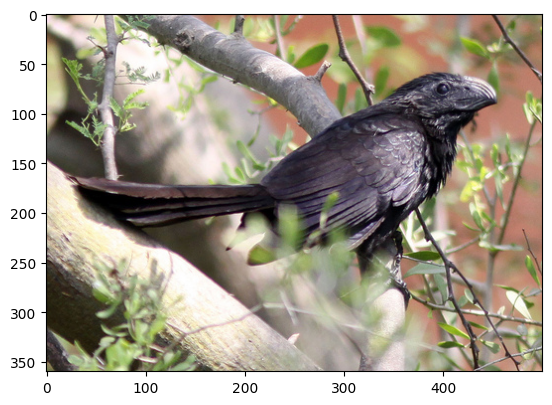

./test/004.Groove_Billed_Ani_0007_1615.jpg
predicted label is:  [1, 2, 3, 3]


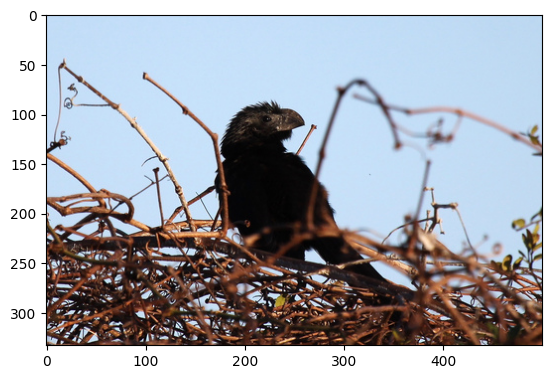

./test/004.Groove_Billed_Ani_0036_1604.jpg
predicted label is:  [1, 2, 3, 3]


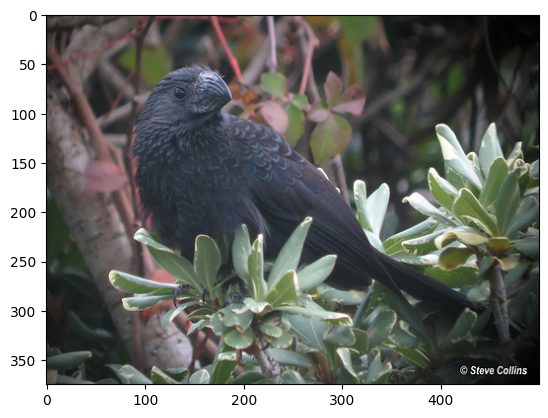

./test/009.Brewer_Blackbird_0014_2679.jpg
predicted label is:  [3, 6, 19, 8]


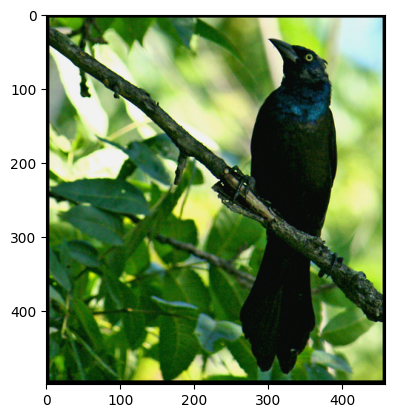

./test/009.Brewer_Blackbird_0066_2693.jpg
predicted label is:  [3, 11, 35, 28]


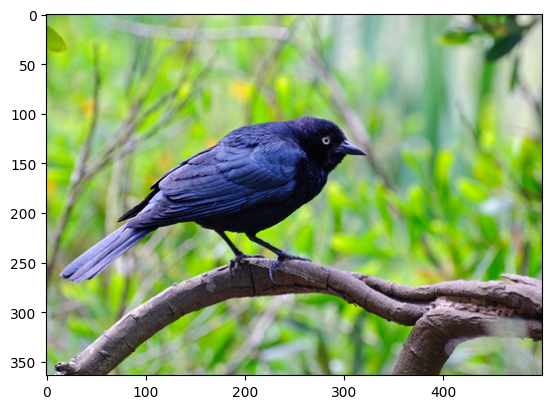

./test/009.Brewer_Blackbird_0082_2593.jpg
predicted label is:  [3, 6, 19, 8]


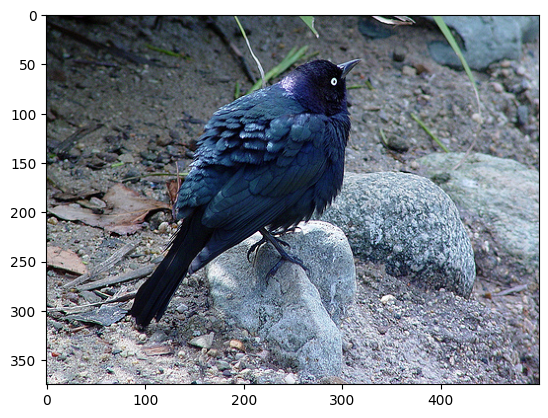

./test/015.Lazuli_Bunting_0025_15079.jpg
predicted label is:  [3, 7, 27, 14]


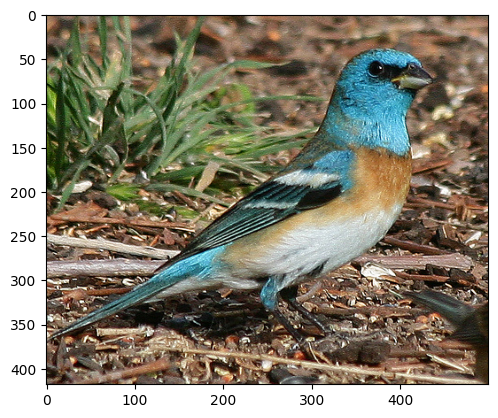

./test/015.Lazuli_Bunting_0039_15081.jpg
predicted label is:  [3, 7, 27, 14]


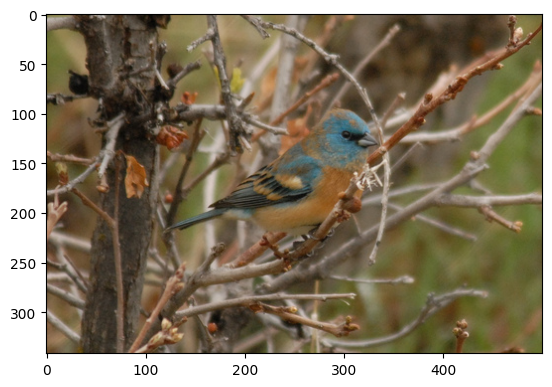

./test/015.Lazuli_Bunting_0047_14863.jpg
predicted label is:  [3, 7, 27, 14]


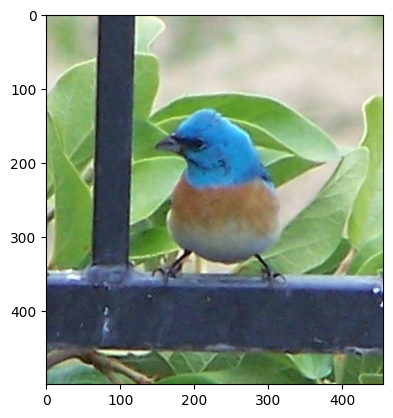

In [4]:
#######################parameter settings##############################
setname = 'CUB_H' #'CUB_H', 'Butterfly_H'
CUDA_VISIBLE_DEVICES = [0]
input_size = 224 #224,448
transfer_mode_test = 'center'

model_name = 'resnet-50-coarse-fine-size-'
model_name += str(input_size) + '-hier'
seed_everything()
gpu_envs_str = set_gpu_envs(CUDA_VISIBLE_DEVICES)
softmax = torch.nn.Softmax(dim=1)

#######################load the hierarchy info########################
label_len,trans_1_to_4,trans_2_to_4,trans_3_to_4 = load_hierarchy_info(setname)
print(label_len)

#######################load the model##################################
model_path = './experiments/'+setname+'/'+model_name+'/code-20230816-183810/last-model.pth'
model = resnet50(num_classes=label_len)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
print('Load the trained model parameters success!')
#model.cuda()
model.eval()

#####################read the test images#######################
test_dir = './test'
listdir = os.listdir(test_dir)

for idx in range(len(listdir)):
    onefile = test_dir+'/'+ listdir[idx]
    print(onefile)
    oneimg_pil = Image.open(onefile)
    imgdata = process_image(oneimg_pil, input_size, transfer_mode_test)
    imgdata = imgdata.float().unsqueeze(0)
    outputs_list = model(imgdata)
    output_v1,output_v2,output_v3,output_v4 = outputs_list
    output_merged = get_fused_output(outputs_list, trans_1_to_4,trans_2_to_4,trans_3_to_4)
    predict_v1 = output_v1.max(1)[1][0].numpy().astype(np.int32).tolist()
    predict_v2 = output_v2.max(1)[1][0].numpy().astype(np.int32).tolist()
    predict_v3 = output_v3.max(1)[1][0].numpy().astype(np.int32).tolist()
    predict_v4 = output_v4.max(1)[1][0].numpy().astype(np.int32).tolist()
    print('predicted label is: ', [predict_v1,predict_v2,predict_v3,predict_v4])
    plt.imshow(np.asarray(oneimg_pil))
    plt.show()
    #break